In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import os
from torchvision import models
from torchvision import transforms
from torch import nn, optim
import torch
from torch.nn import functional as F
import matplotlib
import gc
import os

In [2]:
# gogh_style = [11, 23, 94, 96, 97, 105, 114, 120, 132, 158, 163, 169, 203, 217, 272, 302]
gogh_style = [97, 11, 23, 94, 96, 132, 158, 163, 169, 203, 217, 272, 302]

In [3]:
class PretrainedContentNetwork(nn.Module):
    def __init__(self): 
        super(PretrainedContentNetwork, self).__init__()
        self.sota = models.vgg19(pretrained = True)
        for el in self.sota.parameters():
            el.requires_grad = False
        for i in ([4, 9, 18, 27, 36]):
            self.sota.features[i] = nn.AvgPool2d(2, 2)
    def forward(self, x):
        for i in range(7):
            x = self.sota.features[i](x)
        x = x.view(-1)
        return x
    
class PretrainedStyleNetwork(nn.Module):
    def __init__(self): 
        super(PretrainedStyleNetwork, self).__init__()
        self.sota = models.vgg19(pretrained = True)
        for el in self.sota.parameters():
            el.requires_grad = False
        for i in ([4, 9, 18, 27, 36]):
            self.sota.features[i] = nn.AvgPool2d(2, 2)
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for i in range(2):
            self.slice1.add_module(str(i), self.sota.features[i])
        for i in range(2, 7):
            self.slice2.add_module(str(i), self.sota.features[i])
        for i in range(7, 12):
            self.slice3.add_module(str(i), self.sota.features[i])
        for i in range(12, 21):
            self.slice4.add_module(str(i), self.sota.features[i])
        for i in range(21, 30):
            self.slice5.add_module(str(i), self.sota.features[i])
        del(self.sota)
    def forward(self, x):
        x = self.slice1(x)
        features1 = x.view(x.size()[1], -1)
        gram1 = torch.mm(features1, features1.t()) / features1.size()[1]
        x = self.slice2(x)
        features2 = x.view(x.size()[1], -1)
        gram2 = torch.mm(features2, features2.t()) / features2.size()[1]
        x = self.slice3(x)
        features3 = x.view(x.size()[1], -1)
        gram3 = torch.mm(features3, features3.t()) / features3.size()[1]
        x = self.slice4(x)
        features4 = x.view(x.size()[1], -1)
        gram4 = torch.mm(features4, features4.t()) / features4.size()[1]
        x = self.slice5(x)
        features5 = x.view(x.size()[1], -1)
        gram5 = torch.mm(features5, features5.t()) / features5.size()[1]
        return (gram1, gram2, gram3, gram4, gram5)

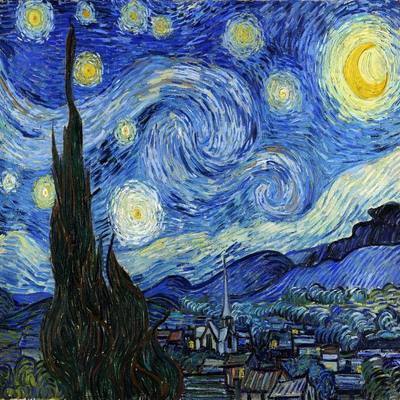

In [4]:
Image.open(f"./GoghResized/real_gogh.jpg").resize((400, 400), Image.LANCZOS)

In [5]:
image_transform = transforms.Compose([transforms.ToTensor()])
content_image = Image.open("./canada-moraine-lake-ozero-gory.jpg").resize((400, 400), Image.LANCZOS)
content_image = image_transform(content_image)
im = torch.rand((3, 400, 400), device = "cuda") / 1000 + 0.5
im.requires_grad = True

In [6]:
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
style_criterion = nn.MSELoss(reduction = 'mean')
content_criterion = nn.MSELoss(reduction = 'mean')

In [7]:
pretrainedContentNet = PretrainedContentNetwork()
pretrainedStyleNet = PretrainedStyleNetwork()
pretrainedStyleNet.to(device)
pretrainedContentNet.to(device)
pretrainedContentNet.eval()
pretrainedStyleNet.eval()
pass

In [8]:
optimizer = optim.Adam({im}, lr = 0.01)

In [9]:
gc.collect()

40

In [10]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.25, patience = 3000, verbose=True)
content_source_preds = pretrainedContentNet(content_image.to(device).view(1, 3, 400, 400))
gogh_grams = []
for number in gogh_style:
    gogh_im = image_transform(Image.open(f"./GoghResized/real_gogh.jpg").resize((400, 400), Image.LANCZOS)).to(device)
    gogh_grams.append(pretrainedStyleNet(gogh_im.to(device).view(1, 3, 400, 400)))
    break
for i in range(100000):
    optimizer.zero_grad()
    content_current_preds = pretrainedContentNet(im.to(device).view(1, 3, 400, 400))
    content_loss = content_criterion(content_source_preds.to(device).view(-1), content_current_preds.to(device).view(-1))
    style_loss = 0
    gen_grams = pretrainedStyleNet(im.to(device).view(1, 3, 400, 400))
    for image_grams in gogh_grams:
        for gram in range(len(image_grams)):
            style_loss += (1 / len(gogh_grams) / len(image_grams)) * style_criterion(gen_grams[gram], image_grams[gram])
    borderloss = ((im > 1) * (im - 1) ** 2) + ((im < 0) * (-im) ** 2)
    loss = 5000 * style_loss + content_loss + torch.sum(borderloss)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    if (i % 1000 == 0):
        minimal = torch.min(im)
        maximal = torch.max(im)
        saveim = (im - minimal) / (maximal - minimal)
        print(i // 1000 + 1, loss.detach().cpu(), style_loss.detach().cpu(), content_loss.detach().cpu())
        print(minimal.detach().cpu(), maximal.detach().cpu())
        matplotlib.image.imsave(f'image{i // 1000}.png', saveim.cpu().detach().numpy().transpose(1, 2, 0))
        np.save(f'numpy_image{i // 1000}.npy', saveim.cpu().detach().numpy().transpose(1, 2, 0))

1 tensor(146.5332) tensor(0.0293) tensor(0.1352)
tensor(0.4900) tensor(0.5110)
2 tensor(0.4065) tensor(2.0540e-05) tensor(0.3038)
tensor(-0.0002) tensor(1.0003)
3 tensor(0.3115) tensor(1.3306e-05) tensor(0.2450)
tensor(-0.0004) tensor(1.0002)
4 tensor(0.2667) tensor(1.1509e-05) tensor(0.2092)
tensor(-0.0003) tensor(1.0005)
5 tensor(0.2435) tensor(1.0453e-05) tensor(0.1912)
tensor(-0.0001) tensor(1.0005)
6 tensor(0.2295) tensor(9.9088e-06) tensor(0.1800)
tensor(-0.0002) tensor(1.0005)


KeyboardInterrupt: 